In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [11]:
labels = pd.read_csv('/kaggle/input/vinbigdata-1024-jpg-dataset/train.csv')
labels.head()

,Unnamed: 0,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,raw_x_min,raw_x_max,raw_y_min,raw_y_max,raw_width,raw_height,scale_x,scale_y
0,0,78aa8415fbf1c792f7d7c53349d44d4f,No finding,14,R16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,3000.0,0.341333,0.341333
1,1,78aa8415fbf1c792f7d7c53349d44d4f,No finding,14,R17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,3000.0,0.341333,0.341333
2,2,78aa8415fbf1c792f7d7c53349d44d4f,No finding,14,R11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,3000.0,0.341333,0.341333
3,3,183015e171f5159d7e60d43578632a3f,Aortic enlargement,0,R8,567.0,295.0,671.0,417.0,1134.0,1342.0,721.0,1019.0,2048.0,2500.0,0.500000,0.409600
4,4,183015e171f5159d7e60d43578632a3f,Pleural thickening,11,R9,58.0,794.0,116.0,851.0,117.0,232.0,1938.0,2077.0,2048.0,2500.0,0.500000,0.409600


In [12]:
labels.describe()

,Unnamed: 0,class_id,x_min,y_min,x_max,y_max,raw_x_min,raw_x_max,raw_y_min,raw_y_max,raw_width,raw_height,scale_x,scale_y
count,67914.000000,67914.000000,36096.000000,36096.000000,36096.000000,36096.000000,36096.000000,36096.000000,36096.000000,36096.000000,67914.000000,67914.000000,67914.000000,67914.000000
mean,33956.500000,9.979312,425.749889,382.143506,606.735151,522.348931,1051.332696,1492.269337,1065.262051,1456.660489,2474.954280,2816.755205,0.422531,0.367986
std,19605.227428,5.036494,219.929360,195.943881,229.786857,204.536511,565.838078,595.384126,552.925133,581.134138,360.818872,297.959417,0.061135,0.042657
min,0.000000,0.000000,0.000000,0.000000,29.000000,35.000000,0.000000,68.000000,0.000000,103.000000,823.000000,927.000000,0.308434,0.300469
25%,16978.250000,7.000000,245.000000,227.000000,412.000000,367.000000,602.000000,1010.000000,627.000000,1009.000000,2256.000000,2500.000000,0.376748,0.333333
50%,33956.500000,13.000000,408.000000,332.000000,652.000000,503.000000,1014.500000,1567.000000,935.000000,1411.000000,2425.000000,2880.000000,0.422268,0.355556
75%,50934.750000,14.000000,578.000000,536.000000,806.000000,691.000000,1457.000000,1947.000000,1471.000000,1911.000000,2718.000000,3072.000000,0.453901,0.409600
max,67913.000000,14.000000,992.000000,987.000000,1024.000000,1024.000000,2934.000000,3131.000000,3133.000000,3384.000000,3320.000000,3408.000000,1.244228,1.104639


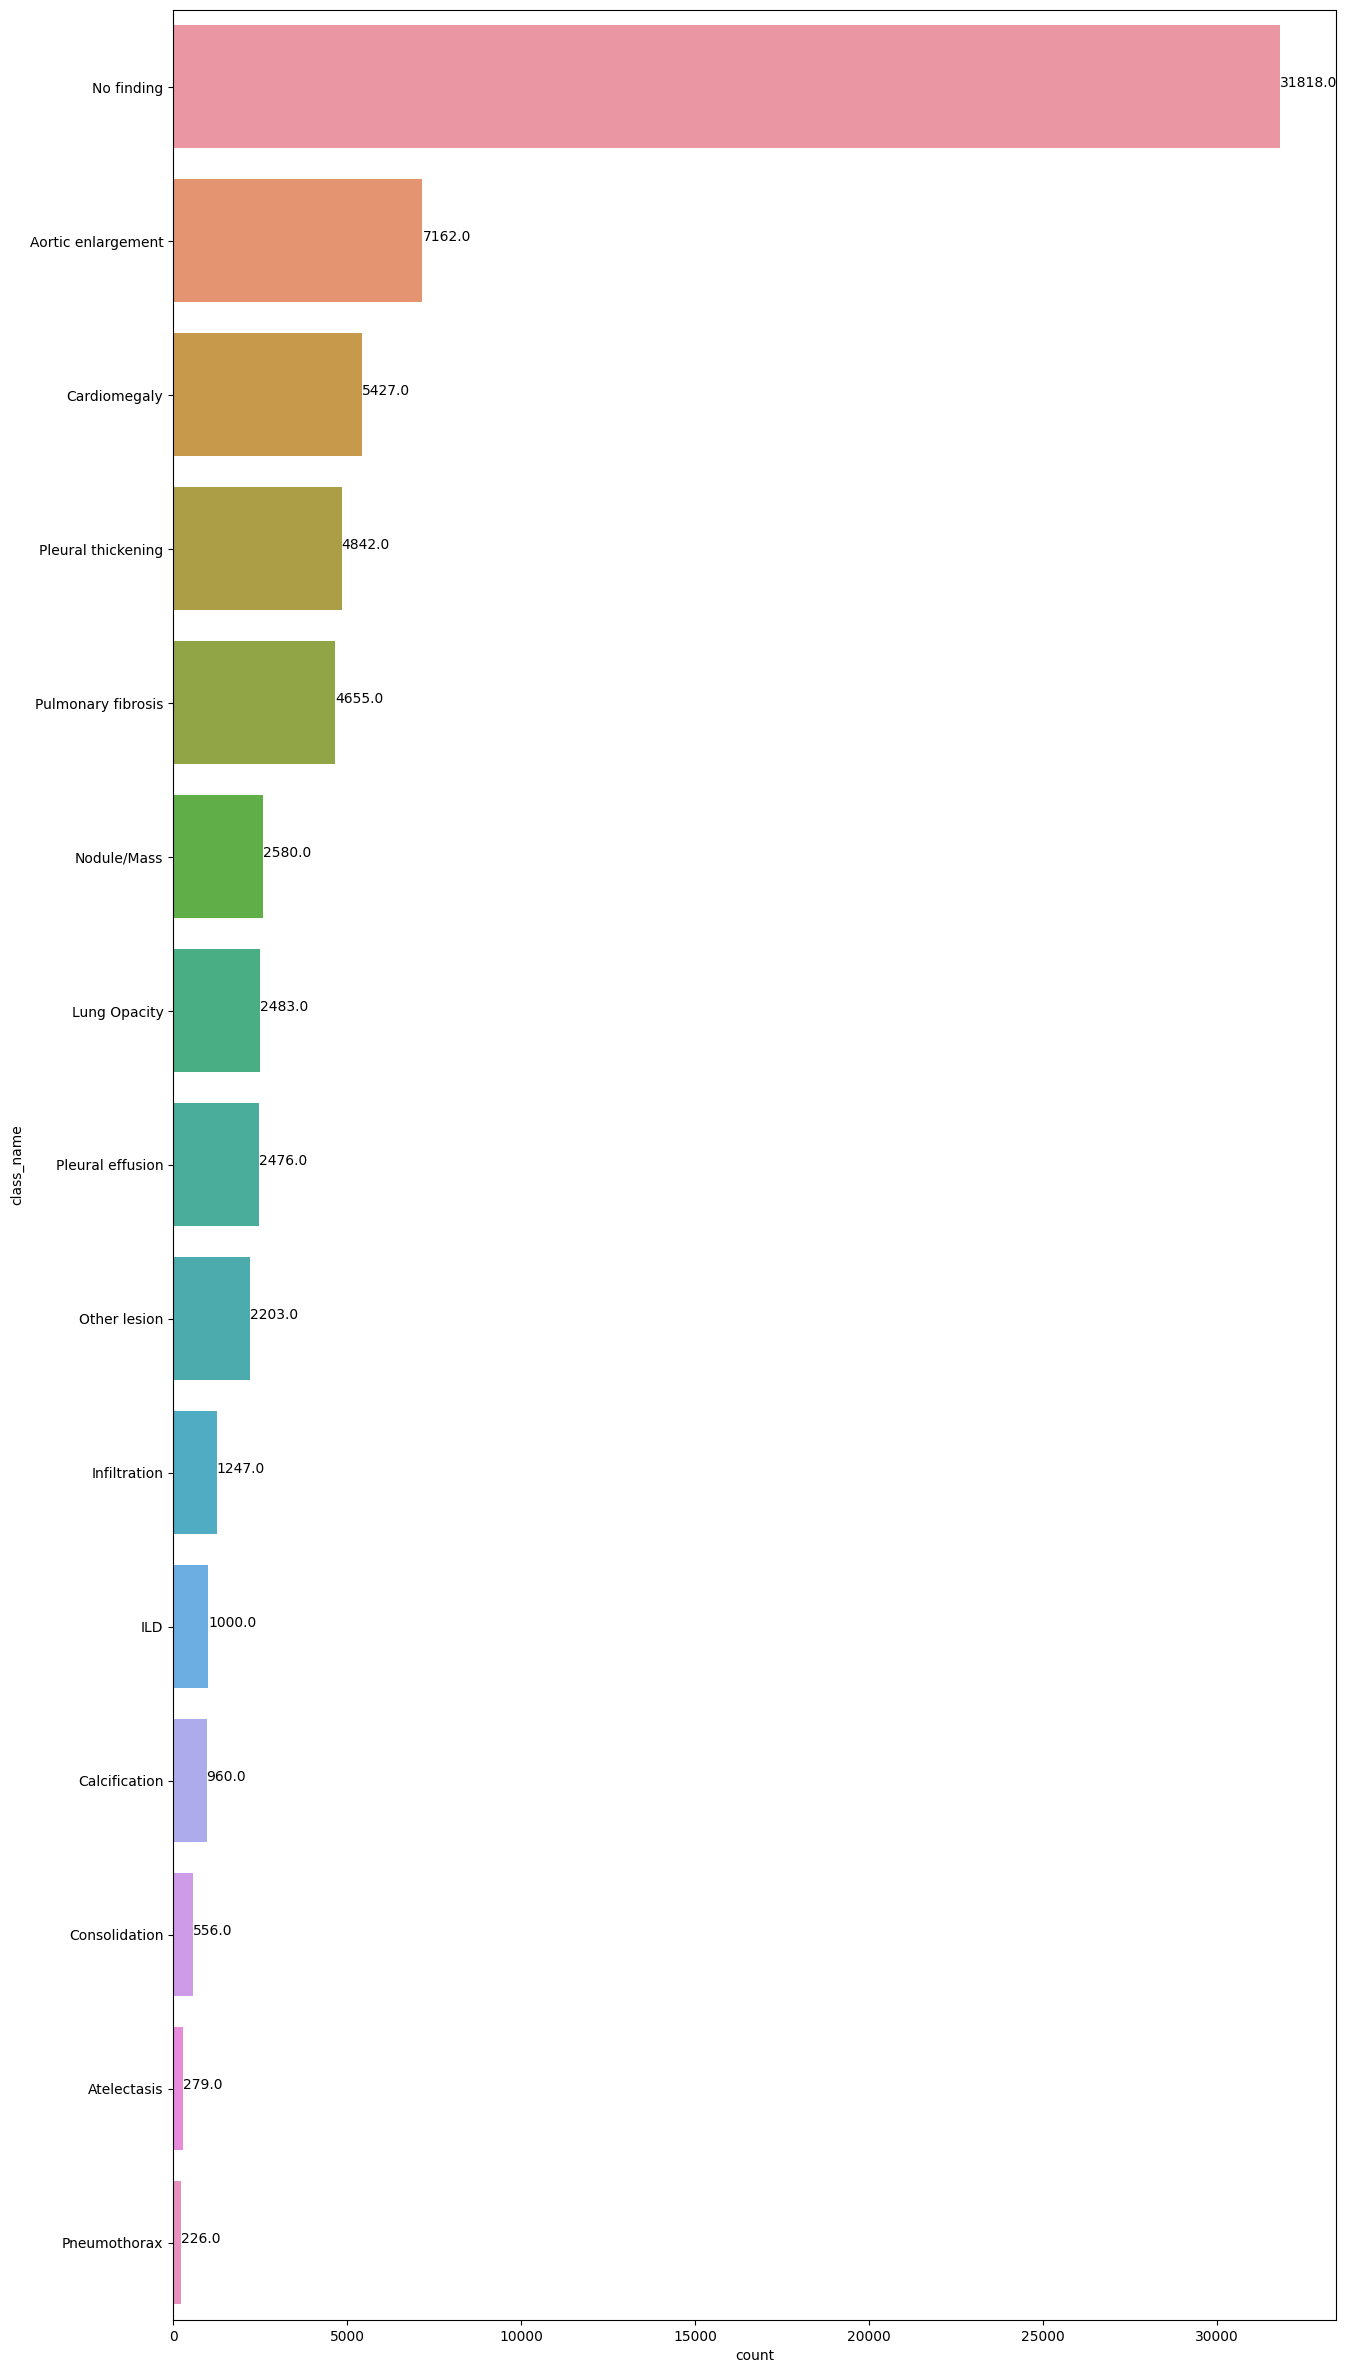

In [13]:
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['class_name'],order=labels['class_name'].value_counts().index)
barw(ax0)
plt.show()

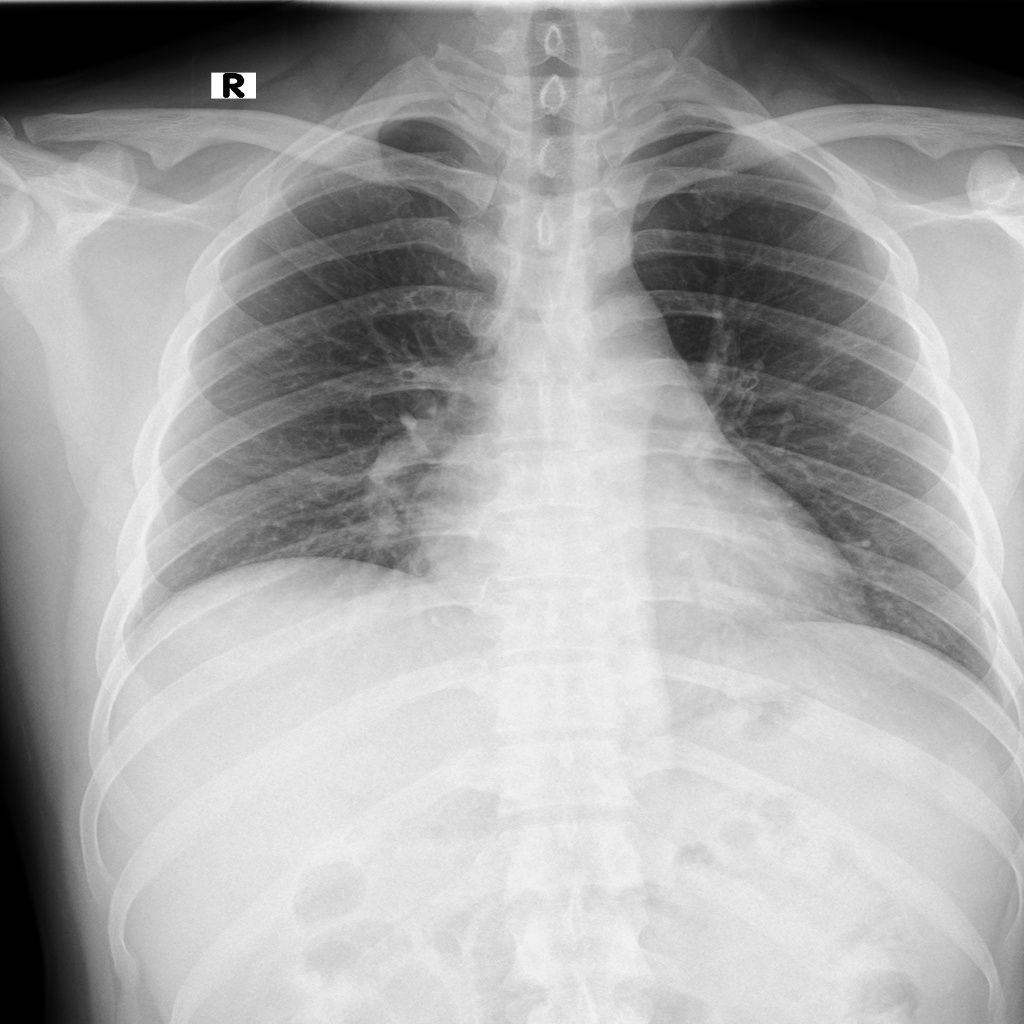

In [14]:
from IPython.display import display, Image
Image("/kaggle/input/vinbigdata-1024-jpg-dataset/train/00575e3846ebd05a909d97ba59c53d30.jpg")


In [15]:
import os
if len(os.listdir('/kaggle/input/vinbigdata-1024-jpg-dataset/train')) == len(labels['image_id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')


Number of file doesnot matches number of actual images!!


In [16]:
classes = sorted(list(set(labels['class_name'])))
n_classes = len(classes)
print('Total unique classes {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique classes 15


{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'No finding': 8,
 'Nodule/Mass': 9,
 'Other lesion': 10,
 'Pleural effusion': 11,
 'Pleural thickening': 12,
 'Pneumothorax': 13,
 'Pulmonary fibrosis': 14}

In [18]:
input_shape = (331,331,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['class_name']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['image_id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        disease_class = image_labels[ix]
        y[ix] = class_to_num[disease_class]
    
    y = to_categorical(y)
    
    return images,y

In [19]:
import time 
t = time.time()

X,y = images_to_array('/kaggle/input/vinbigdata-1024-jpg-dataset/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/67914 [00:00<?, ?it/s]

runtime in seconds: 733.488287448883


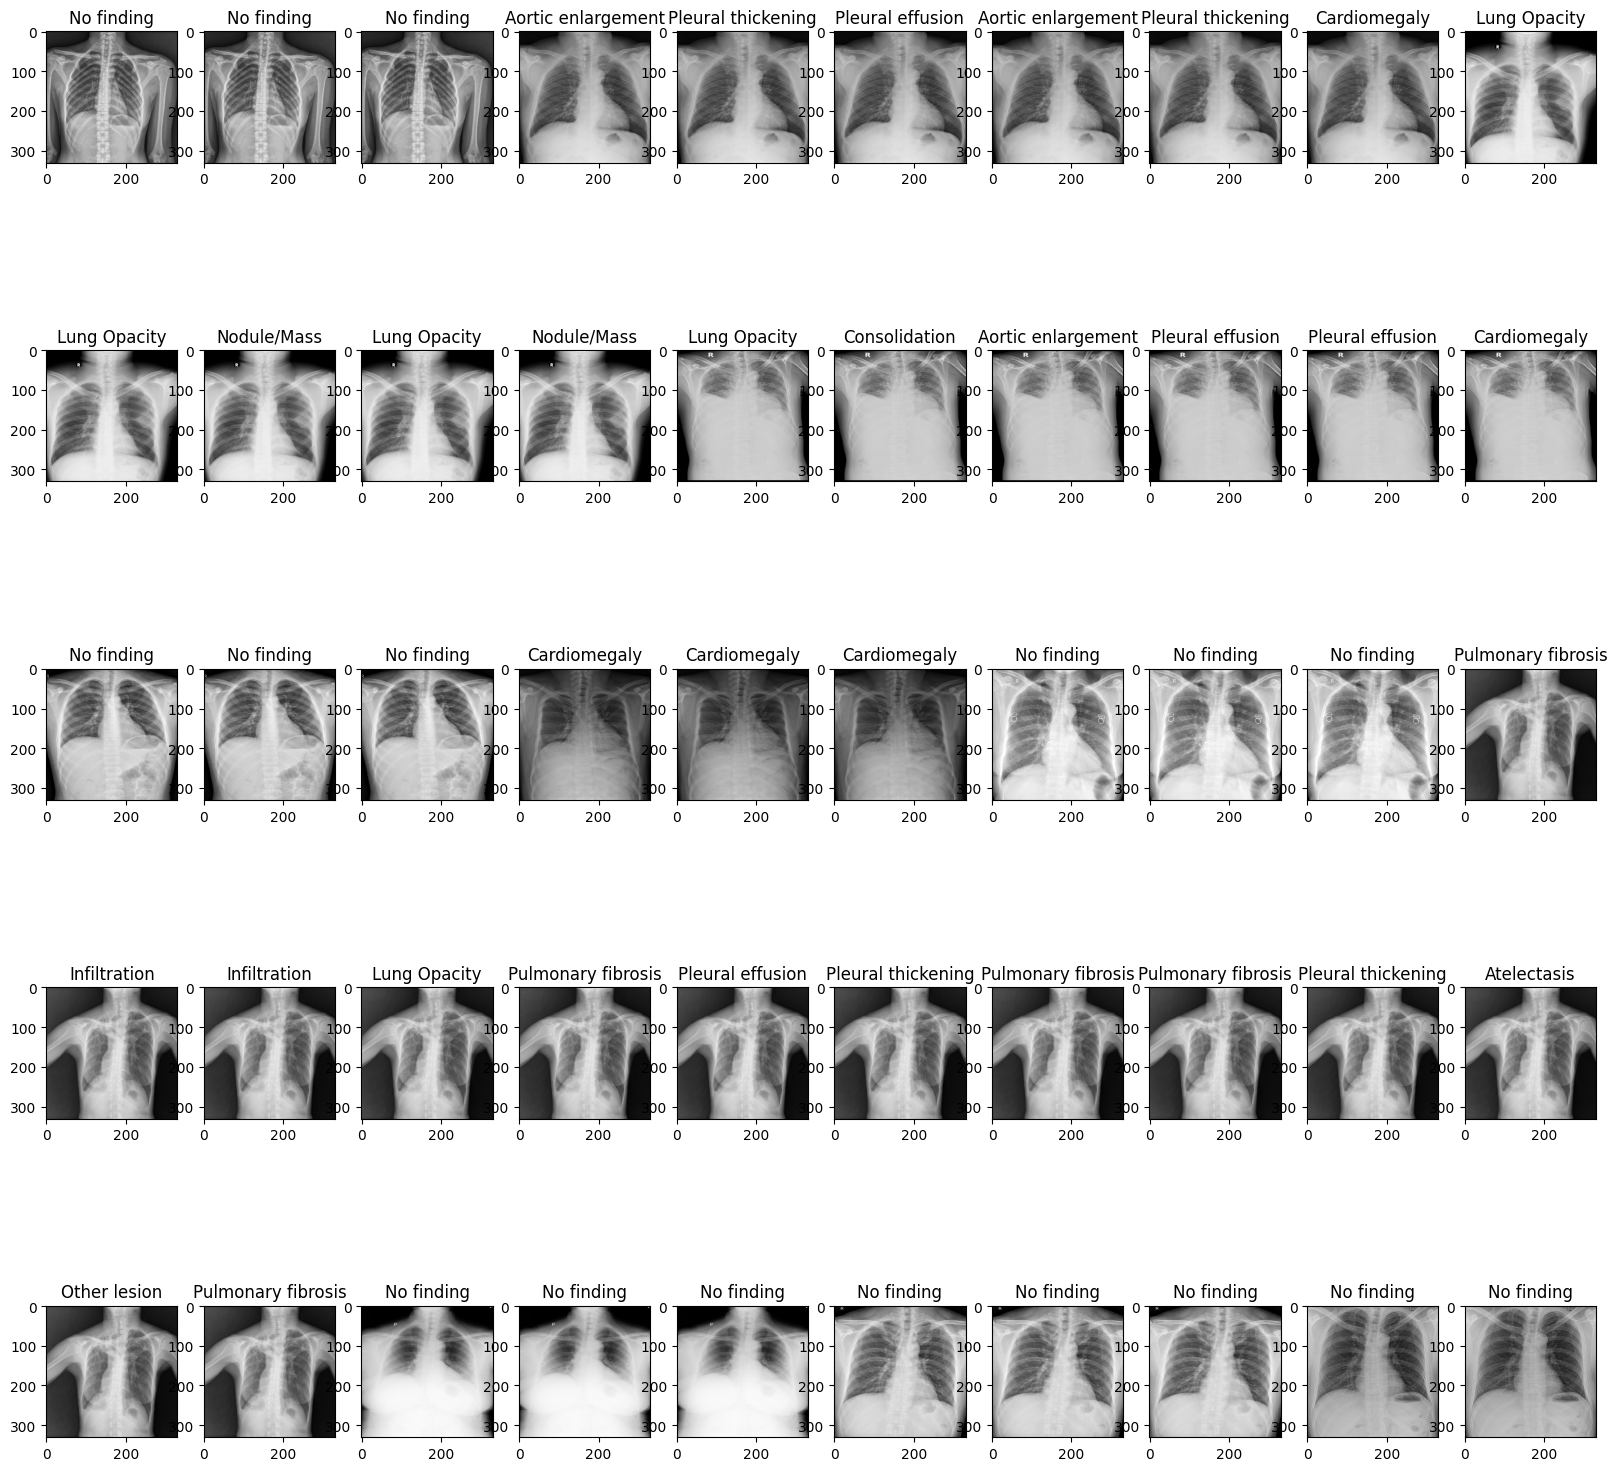

In [22]:
# np.where(y[5]==1)[0][0]

# lets check some diseases
n=50

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 10, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image

In [23]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [26]:
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

In [ ]:
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

In [ ]:
del X #to free up some ram memory
gc.collect()

In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

In [ ]:
#Prepare Deep net

model = Sequential()
# model.add(Dense(1028,input_shape=(final_features.shape[1],)))
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

In [ ]:
del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

In [ ]:
def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/kaggle/input/dog-breed-identification/test/', img_size)

In [ ]:
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

test_features = extact_features(test_data)

In [ ]:
del test_data
gc.collect()

In [ ]:
pred = model.predict(test_features)

In [ ]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

In [ ]:
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "/kaggle/input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()

In [ ]:
Image('../input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [ ]:
img_g = load_img('../input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0) 

In [ ]:
img_g.shape

In [ ]:
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")